<h1 align=center><font size = 6> Segmenting and Clustering Neighborhoods in Paris City <font/><h1/>

## Introduction

In this notebook, we are going to see the segmenting and clustering neighborhoods in Paris city. the segmentation will be on two levels: Neighborhood's population and (type and number) business venue. First, we will collect data about the Paris city as like name and coordinates geographics neighborhood and Paris business venues. Secondly, we will use it  to understand and analysis. Thirdly, we will apply k-means method in order to segment data and lastly, we will analyse the result of clustering.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
1. <a href="#item1">Data Collection</a>  
    1.1. <a href="#item1.1">Names and Geographic Coordinates of Neighborhoods</a>
    1.2. <a href="#item1.2">Venues of Neighborhoods</a> 2. <a href="#item2">Data Analysis</a>
    
    2.1 <a href="#item2.1">Data of Names and Geographic Coordinates of Neighborhoods</a>
    
    2.2 <a href="#item2.2">Data of Venues of Neighborhoods</a>
    

3. <a href="#item3">Application of the method</a>

</font>
</div>

<a id='item1'></a>

## 1. Data Collection

<a id='item1.1'></a>

###  1.1 Names and Geographic Coordinates of Neighborhoods

Import some packages for using to collect data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Get the content of wiki page

In [33]:
url_wiki = 'https://fr.wikipedia.org/wiki/Liste_des_quartiers_administratifs_de_Paris'
centent_wiki = requests.get(url_wiki).text # get the content of wiki page

Intialize the object BeautifulSoup by wiki content in order ot parser it 

In [34]:
soup = BeautifulSoup(centent_wiki,'lxml')

Extract the table form the content.

In [35]:
table = soup.find('table',{'class':'wikitable sortable'})

Get the table header.

In [14]:
columns_names = table.find_all('th')
columns_names = [col.text.strip() for col in  columns_names]
columns_names

['Arrondissement[1],[n 1]',
 'Quartiers',
 'Population en1999 (hab.)[2]',
 'Superficie(ha)[2]',
 'Densitéhab/km2',
 'Plan']

Rename table header in english languge.

In [21]:
columns_names_0 = ['borough','Rank','Neighborhood','Population','Area','Density']

Extract Data table 

In [22]:
df_Paris = pd.DataFrame(columns=columns_names_0) # Intialize the Paris DataFrame
name_boroughs = ''
table_rows = table.find_all('tr')  # Find rows table
for row in table_rows :
    tds = row.find_all('td')    # Find cells table
    row1 = [td.text.strip() for td in tds]
    if (len(row1)==7) :   #since, there are rows have 7 cells and others have 5 cells.
        row1 = row1[0:len(row)-1]
        name_boroughs = row1[0]
        dict_row = {}
        for cell , col_name in zip( row1,columns_names_0) :
            dict_row[col_name] = cell
        df_Paris = df_Paris.append(dict_row, ignore_index=True)
    if(len(row1)==5):   #since, there are rows have 7 cells and others have 5 cells.
        dict_row = {}
        dict_row[columns_names_0[0]] = name_boroughs
        for cell , col_name in zip( row1,columns_names_0[1:]) :
            dict_row[col_name] = cell    
        df_Paris = df_Paris.append(dict_row, ignore_index=True)

In [23]:
df_Paris.head()

,borough,Rank,Neighborhood,Population,Area,Density
0,1er arrondissementdit « du Louvre »,1er,Saint-Germain-l'Auxerrois,1 672,"86,9",1 924
1,1er arrondissementdit « du Louvre »,2e,Halles,8 984,"41,2",21 806
2,1er arrondissementdit « du Louvre »,3e,Palais-Royal,3 195,"27,4",11 661
3,1er arrondissementdit « du Louvre »,4e,Place-Vendôme,3 044,"26,9",11 316
4,2e arrondissementdit « de la Bourse »,5e,Gaillon,1 345,"18,8",7 154


Ckeck the number of Neighborhoods and boroughs

In [26]:
df_Paris.shape

(80, 6)

Get Latitude and Longitude For each Neighborhood, to do this , we will extract the link of each Neighborhood in the wiki table, and  go to each link in order to extract the coordinates Geographics

In [27]:
def get_latitude_longitude (location) :    # location is the name of a neighborhood 
    location = re.split('\(',location)[0].strip()
    #print(location.strip())
    link = soup.find('a',text=location).get('href') #extract the link from the content page
    #soup.find('a',text='Acton').get()
    link = 'https://fr.wikipedia.org'+link
    
    content = requests.get(link).text
    soup2 = BeautifulSoup(content,'lxml')
    coor = soup2.find('span',{'class':'noprint'})
    long = float(coor.a['data-lon'])
    lat = float(coor.a['data-lat'])
    return pd.Series((long,lat))

Test Function for "Palais-Royal" neighborhood 

In [30]:
get_latitude_longitude('Palais-Royal')

0     2.337749
1    48.864912
dtype: float64

Get all Longitudes,Latitudes of neighborhoods.

In [31]:
df_Paris [['Longitude','Latitude']] =  df_Paris.apply(lambda row: get_latitude_longitude(row['Neighborhood']),axis=1)

In [32]:
df_Paris.head()

,borough,Rank,Neighborhood,Population,Area,Density,Longitude,Latitude
0,1er arrondissementdit « du Louvre »,1er,Saint-Germain-l'Auxerrois,1 672,"86,9",1 924,2.340195,48.860112
1,1er arrondissementdit « du Louvre »,2e,Halles,8 984,"41,2",21 806,2.344744,48.862541
2,1er arrondissementdit « du Louvre »,3e,Palais-Royal,3 195,"27,4",11 661,2.337749,48.864912
3,1er arrondissementdit « du Louvre »,4e,Place-Vendôme,3 044,"26,9",11 316,2.329402,48.867495
4,2e arrondissementdit « de la Bourse »,5e,Gaillon,1 345,"18,8",7 154,2.332867,48.869083


Check number of invalid cells in table.

In [34]:
len(df_Paris[pd.isnull(df_Paris).any(axis=1)])

0

Check if there are Neighborhoods that have same coordinates geographic .

In [38]:
len(df_Paris[df_Paris.duplicated(['Longitude','Latitude'],keep=False)])

0

Get the coordinate geographic of the city center.

In [60]:
from geopy.geocoders import Nominatim

In [61]:
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris City are 48.8566101, 2.3514992.


Let's see the map of Paris city with its neighborhoods 

In [43]:
import folium

In [45]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Paris['Latitude'], df_Paris['Longitude'], df_Paris['borough'], df_Paris['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

Calculate in km the distance of each neighborhood from the center city.

In [47]:
import geopy.distance
def distance_2_points(long1,lat1,long2,lat2) :
    coords_1 = (lat1, long1)
    coords_2 = (lat2, long2)
    
    return(geopy.distance.vincenty(coords_1, coords_2).km)

Save table 

In [ ]:
df_Paris.head()

In [54]:
df_Paris.to_csv('List_neighbourhood_paris_city.csv',index=False)

### 2. Collect venues of Neighborhood

<a id='item1.2'></a>

In [192]:
df_Paris = pd.read_csv('List_neighbourhood_paris_city.csv')

I am going to use Foursquare API to collect venues data in each neighborhood Paris.

To do this, we must neighborhoods names !!!

In [4]:
df_Paris.head(3)

,borough,Rank,Neighborhood,Population,Area,Density,Longitude,Latitude,Distance_center
0,1er arrondissementdit « du Louvre »,1er,Saint-Germain-l'Auxerrois,1 672,"86,9",1 924,2.340195,48.860112,0.916353
1,1er arrondissementdit « du Louvre »,2e,Halles,8 984,"41,2",21 806,2.344744,48.862541,0.824991
2,1er arrondissementdit « du Louvre »,3e,Palais-Royal,3 195,"27,4",11 661,2.337749,48.864912,1.367567


In [5]:
import requests

We must insert some personal information to access to API

In [7]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

A Function to get all informations about Neighborhoods venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['country'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Country',
                  'Venue Category']
    
    return(nearby_venues)

In [69]:
LIMIT = 100
df_venues = getNearbyVenues(names=df_Paris['Neighborhood'],
                latitudes=df_Paris['Latitude'],
                longitudes=df_Paris['Longitude'])

Saint-Germain-l'Auxerrois
Halles
Palais-Royal
Place-Vendôme
Gaillon
Vivienne
Mail
Bonne-Nouvelle
Arts-et-Métiers
Enfants-Rouges
Archives
Sainte-Avoye
Saint-Merri
Saint-Gervais
Arsenal
Notre-Dame
Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Saint-Thomas-d'Aquin
Invalides
École-Militaire
Gros-Caillou
Champs-Élysées
Faubourg-du-Roule
Madeleine
Europe
Saint-Georges
Chaussée-d'Antin
Faubourg-Montmartre
Rochechouart
Saint-Vincent-de-Paul
Porte-Saint-Denis
Porte-Saint-Martin
Hôpital-Saint-Louis
Folie-Méricourt
Saint-Ambroise
Roquette
Sainte-Marguerite
Bel-Air
Picpus
Bercy
Quinze-Vingts
Salpêtrière
Gare
Maison-Blanche
Croulebarbe
Montparnasse
Parc-de-Montsouris
Petit-Montrouge
Plaisance
Saint-Lambert
Necker
Grenelle
Javel
Auteuil
Muette
Porte-Dauphine
Chaillot
Ternes
Plaine-de-Monceaux
Batignolles
Épinettes
Grandes-Carrières
Clignancourt
Goutte-d'Or
Chapelle
Villette
Pont-de-Flandre
Amérique
Combat
Belleville
Saint-Fargeau
Pèr

In [70]:
df_venues.to_csv('List_venues_paris.csv',index=False)

In [2]:
df_venues = pd.read_csv('List_venues_paris.csv')

 Get data about Foursqare Categories

Some venues information

In [3]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Country,Venue Category
0,Saint-Germain-l'Auxerrois,48.860112,2.340195,Cour Carrée du Louvre,48.860360,2.338543,France,Pedestrian Plaza
1,Saint-Germain-l'Auxerrois,48.860112,2.340195,Place du Louvre,48.859841,2.340822,France,Plaza
2,Saint-Germain-l'Auxerrois,48.860112,2.340195,Le Fumoir,48.860341,2.340647,France,Cocktail Bar
3,Saint-Germain-l'Auxerrois,48.860112,2.340195,Église Saint-Germain l'Auxerrois,48.859887,2.340617,France,Church
4,Saint-Germain-l'Auxerrois,48.860112,2.340195,La Régalade Saint-Honoré,48.861620,2.341749,France,French Restaurant


In [ ]:

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
results = requests.get(url).json()
cats = results['response']['categories']


See First Category and its sub-categories !!!

In [14]:
cats[0]

{'id': '4d4b7104d754a06370d81259',
 'name': 'Arts & Entertainment',
 'pluralName': 'Arts & Entertainment',
 'shortName': 'Arts & Entertainment',
 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
  'suffix': '.png'},
 'categories': [{'id': '56aa371be4b08b9a8d5734db',
   'name': 'Amphitheater',
   'pluralName': 'Amphitheaters',
   'shortName': 'Amphitheater',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/default_',
    'suffix': '.png'},
   'categories': []},
  {'id': '4fceea171983d5d06c3e9823',
   'name': 'Aquarium',
   'pluralName': 'Aquariums',
   'shortName': 'Aquarium',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/aquarium_',
    'suffix': '.png'},
   'categories': []},
  {'id': '4bf58dd8d48988d1e1931735',
   'name': 'Arcade',
   'pluralName': 'Arcades',
   'shortName': 'Arcade',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/arcade_',
    

a Function to parse data.

In [15]:
def get_categories(categories , liste = []): # Extract names sub-category 
    if categories and type(categories==list):
        for category in categories :
                if 'name' in category :
                    liste.append(category['name'])
                if 'categories' in category:
                     get_categories(category['categories'],liste)
    return liste

Extract names sub-category for each category

In [16]:
dict_categories = {}
for i in range(len(cats))  :
        dict_categories[cats[i]['name']] = get_categories(cats[i]['categories'],liste = [])

Let's see sub-categories of 'Arts & Entertainment' category !!

In [8]:
dict_categories['Arts & Entertainment']

['Amphitheater',
 'Aquarium',
 'Arcade',
 'Art Gallery',
 'Bowling Alley',
 'Casino',
 'Circus',
 'Comedy Club',
 'Concert Hall',
 'Country Dance Club',
 'Disc Golf',
 'Exhibit',
 'General Entertainment',
 'Go Kart Track',
 'Historic Site',
 'Karaoke Box',
 'Laser Tag',
 'Memorial Site',
 'Mini Golf',
 'Movie Theater',
 'Drive-in Theater',
 'Indie Movie Theater',
 'Multiplex',
 'Museum',
 'Art Museum',
 'Erotic Museum',
 'History Museum',
 'Planetarium',
 'Science Museum',
 'Music Venue',
 'Jazz Club',
 'Piano Bar',
 'Rock Club',
 'Pachinko Parlor',
 'Performing Arts Venue',
 'Dance Studio',
 'Indie Theater',
 'Opera House',
 'Theater',
 'Pool Hall',
 'Public Art',
 'Outdoor Sculpture',
 'Street Art',
 'Racecourse',
 'Racetrack',
 'Roller Rink',
 'Salsa Club',
 'Samba School',
 'Stadium',
 'Baseball Stadium',
 'Basketball Stadium',
 'Cricket Ground',
 'Football Stadium',
 'Hockey Arena',
 'Rugby Stadium',
 'Soccer Stadium',
 'Tennis Stadium',
 'Track Stadium',
 'Theme Park',
 'Theme Pa

Visualize categories data 

<a id='item2'></a>

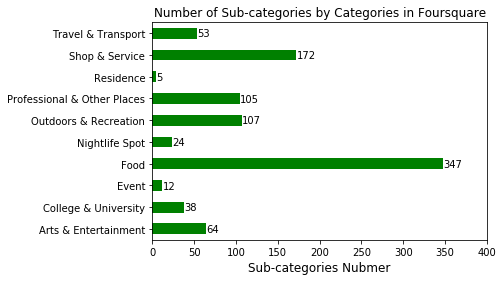

In [9]:
ss = pd.Series(dict_categories)
ax = ss.map(len).plot.barh(color='g')
ax.set_xlabel("Sub-categories Nubmer", fontsize=12)
for i in ax.patches:
    ax.text(i.get_width()+0.3,i.get_y()+0.1 ,str(round(i.get_width(),2)) )
ax.set_xlim(0, 400)
plt.title('Number of Sub-categories by Categories in Foursquare')
plt.savefig('Foursquare_categories.png',pad_inches=0.5,bbox_inches='tight')

## 2. Data Analysis 

<a id='item2'></a>

<a id='item2.1'></a>

### 2.1 Data of Names and Geographic Coordinates of Neighborhood

In [46]:
df_Paris = pd.read_csv('List_neighbourhood_paris_city.csv')

In [47]:
df_Paris.head(3)

,borough,Rank,Neighborhood,Population,Area,Density,Longitude,Latitude,Distance_center
0,1er arrondissementdit « du Louvre »,1er,Saint-Germain-l'Auxerrois,1 672,"86,9",1 924,2.340195,48.860112,0.916353
1,1er arrondissementdit « du Louvre »,2e,Halles,8 984,"41,2",21 806,2.344744,48.862541,0.824991
2,1er arrondissementdit « du Louvre »,3e,Palais-Royal,3 195,"27,4",11 661,2.337749,48.864912,1.367567


Check Types Data !!

In [48]:
df_Paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
borough            80 non-null object
Rank               80 non-null object
Neighborhood       80 non-null object
Population         80 non-null object
Area               80 non-null object
Density            80 non-null object
Longitude          80 non-null float64
Latitude           80 non-null float64
Distance_center    80 non-null float64
dtypes: float64(3), object(6)
memory usage: 5.7+ KB


We must change  the tpe of population column to float !!

In [49]:
df_Paris["Population"] = df_Paris.Population.apply(lambda x : int(x.replace('\xa0', '')))

Population of Paris city 

In [14]:
df_Paris["Population"].sum()

2125851

The Population distribution.  
We have almost 20 neighborhoods less than 10 thousand !!!

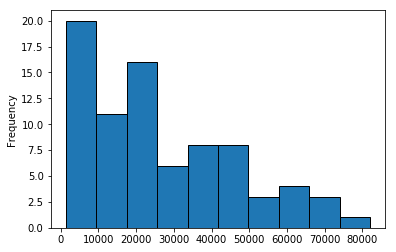

In [15]:
df_Paris["Population"].plot.hist(edgecolor='black')

The relation between the number of population and the distance to the city center !!

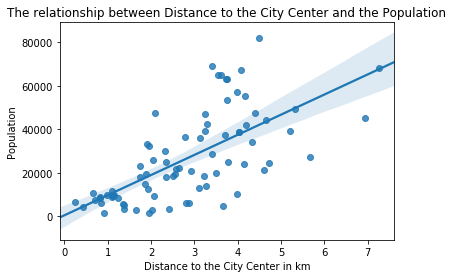

In [22]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.regplot(x='Distance_center', y='Population', data=df_Paris)
ax.set(xlabel='Distance to the City Center in km')
plt.title('The relationship between Distance to the City Center and the Population')
plt.savefig('Population_distance_center.png',transparent=False,bbox_inches='tight')

<a id='item2.2'></a>

## 2.2 Data of Venues of Neighborhoods

In [8]:
df_venues = pd.read_csv('List_venues_paris.csv')

Since we will apply a filtering on venues, we have to get the number of veniues before filtering.

In [9]:
Number_venues_before = df_venues.shape[0]
Number_venues_before

5728

In [10]:
df_venues['Venue Category'].value_counts().describe(include='all')

count    306.000000
mean      18.718954
std       57.435062
min        1.000000
25%        2.000000
50%        5.000000
75%       15.000000
max      769.000000
Name: Venue Category, dtype: float64

We notice that most of venues categories repeat less than 5 times

Now, we are going to apply a filtering on venues according on its categories!!

In [17]:
def check_categories(name): # get the category name  of each sub_category 
    if name in dict_categories:
        return name;
    for k, v in dict_categories.items():
        if name in dict_categories[k] :
            return k
    return False

In [18]:
df_venues['Top Category'] = df_venues['Venue Category'].apply(check_categories)
ss = df_venues['Top Category'].value_counts() # series of category before filtering, we are going to use it for visualization

In [19]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Country,Venue Category,Top Category
0,Saint-Germain-l'Auxerrois,48.860112,2.340195,Cour Carrée du Louvre,48.860360,2.338543,France,Pedestrian Plaza,Outdoors & Recreation
1,Saint-Germain-l'Auxerrois,48.860112,2.340195,Place du Louvre,48.859841,2.340822,France,Plaza,Outdoors & Recreation
2,Saint-Germain-l'Auxerrois,48.860112,2.340195,Le Fumoir,48.860341,2.340647,France,Cocktail Bar,Nightlife Spot
3,Saint-Germain-l'Auxerrois,48.860112,2.340195,Église Saint-Germain l'Auxerrois,48.859887,2.340617,France,Church,Professional & Other Places
4,Saint-Germain-l'Auxerrois,48.860112,2.340195,La Régalade Saint-Honoré,48.861620,2.341749,France,French Restaurant,Food


Initialize the sub-categories that we are going to use in order to filter the venues !!

In [20]:
dict_categories_filter = {}

In [21]:
dict_categories_filter['Arts & Entertainment'] = ['Bowling Alley','Casino','Circus','Country Dance Club'\
,'General Entertainment','Laser Tag','Movie Theater','Drive-in Theater','Indie Movie Theater','Multiplex']

dict_categories_filter['Outdoors & Recreation'] = ['Gym / Fitness Center','Boxing Gym','Climbing Gym',\
'Gymnastics Gym','Gym','Outdoor Gym']

dict_categories_filter['Travel & Transport'] = ['Hotel','Bed & Breakfast','Boarding House','Hostel',\
'Hotel Pool','Inn','Motel','Resort','Vacation Rental']

dict_categories_filter['Food'] = dict_categories['Food']
dict_categories_filter['Nightlife Spot'] = dict_categories['Nightlife Spot']
dict_categories_filter['Shop & Service'] = dict_categories['Shop & Service']

Function of filtering

In [22]:
def filter_category(name):
    #print(row['Venue Category'])
    top_category = check_categories(name)#row['Venue Category']
    if (top_category in dict_categories_filter) \
    and ( name in dict_categories_filter[top_category] or name == top_category) :#row['Venue Category']
        return True
    return False

In [23]:
df_venues = df_venues[df_venues['Venue Category'].apply(filter_category)]

In [24]:
df_venues.reset_index(inplace = True,drop=True)
df_venues.head(2)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Country,Venue Category,Top Category
0,Saint-Germain-l'Auxerrois,48.860112,2.340195,Le Fumoir,48.860341,2.340647,France,Cocktail Bar,Nightlife Spot
1,Saint-Germain-l'Auxerrois,48.860112,2.340195,La Régalade Saint-Honoré,48.861620,2.341749,France,French Restaurant,Food


In [25]:
Number_venues_after = df_venues.shape[0]
Number_venues_after

5109

In [26]:
print ( 'the number of venues removed is ', Number_venues_before-Number_venues_after)

the number of venues removed is  619


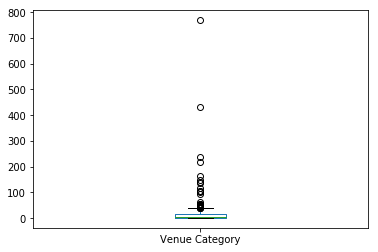

In [27]:
df_venues['Venue Category'].value_counts().plot.box()

After filtering, the venues categories still repeat less than 5 times

Let's see the venues categories that repeat more than 100 times

In [28]:
Venue_Category = df_venues['Venue Category'].value_counts()

In [29]:
Venue_Category[Venue_Category>100]

French Restaurant      769
Hotel                  433
Italian Restaurant     239
Bar                    217
Bakery                 164
Café                   149
Bistro                 139
Japanese Restaurant    135
Pizza Place            116
Wine Bar               106
Restaurant             105
Coffee Shop            103
Name: Venue Category, dtype: int64

Let's see some venues categories that repeat one time

In [30]:
Venue_Category[Venue_Category==1].head()

EV Charging Station     1
Pop-Up Shop             1
Cantonese Restaurant    1
Food Service            1
Malay Restaurant        1
Name: Venue Category, dtype: int64

Let's Compare the number of venues for each category before and after filtering

In [31]:
import math

In [32]:
ss1 = df_venues['Top Category'].value_counts() # series of category after filtering
df_plot = pd.concat([ss,ss1],axis=1,sort=False)
df_plot

,Top Category,Top Category
Food,3278,3278.0
Shop & Service,723,723.0
Nightlife Spot,566,566.0
Travel & Transport,480,452.0
Outdoors & Recreation,329,49.0
Arts & Entertainment,326,41.0
Professional & Other Places,24,NaN
College & University,2,NaN


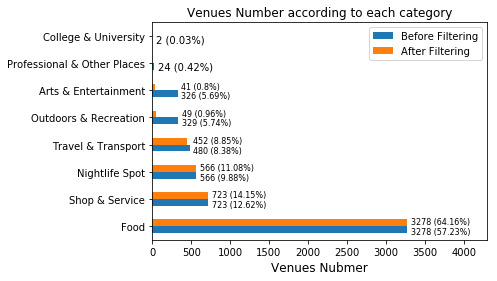

In [33]:
fig, ax = plt.subplots()

df_plot.columns = ['Before Filtering', 'After Filtering']
df_plot.plot.barh(ax=ax)

for i in range(len(ss)) :
    if math.isnan(df_plot.iloc[i,1]):
        percent = (df_plot.iloc[i,0]/Number_venues_before)*100
        text = '{} ({}%)'.format(df_plot.iloc[i,0],round(percent,2))
        ax.text(df_plot.iloc[i,0]+50,i-0.25 ,text,size=10 )
    else:
        percent = (df_plot.iloc[i,0]/Number_venues_before)*100
        text1 = '{} ({}%)'.format(df_plot.iloc[i,0],round(percent,2))
        ax.text(df_plot.iloc[i,0]+50,i-0.3 ,text1,size=8)
        percent = (df_plot.iloc[i,1]/Number_venues_after)*100
        text2 = '{} ({}%)'.format(int(df_plot.iloc[i,1]),round(percent,2))
        ax.text(df_plot.iloc[i,0]+50,i+0.06 ,text2,size=8 )
ax.set_xlim(0, 4300)
ax.set_xlabel("Venues Nubmer", fontsize=12)
plt.title('Venues Number according to each category')
plt.savefig('Venue_categories_Number_2.png',bbox_inches='tight')

<a id='item3'></a>

## 3. Application of the method

Preparing data to for applying method

In [123]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']],prefix="",prefix_sep="")
df_onehot.insert(0,'Neighborhoods',df_venues['Neighborhood'])

In [124]:
df_grouped = df_onehot.groupby('Neighborhoods').sum().reset_index()

Each cell represents the number of category number compared to aany neighborhood !!

In [125]:
df_grouped.head()

,Neighborhoods,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Arts & Crafts Store,...,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Amérique,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Archives,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2,Arsenal,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,1,0,0
3,Arts-et-Métiers,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,3,4,1,0
4,Auteuil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's see the first ten venues categories for each neighborhood

In [126]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [127]:
import numpy as np

In [128]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = df_grouped['Neighborhoods']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(5)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Café,Grocery Store,Bakery,Pizza Place,Brewery,Supermarket,Bistro,Ethiopian Restaurant,Fabric Shop
1,Archives,French Restaurant,Clothing Store,Cocktail Bar,Pastry Shop,Coffee Shop,Bookstore,Creperie,Café,Bistro,Tea Room
2,Arsenal,French Restaurant,Italian Restaurant,Gastropub,Hotel,Cocktail Bar,Bakery,Thai Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Seafood Restaurant
3,Arts-et-Métiers,French Restaurant,Hotel,Japanese Restaurant,Wine Bar,Bar,Italian Restaurant,Coffee Shop,Cocktail Bar,Restaurant,Chinese Restaurant
4,Auteuil,Outdoors & Recreation,Restaurant,Circus,Women's Store,EV Charging Station,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


Now , let's apply the k-means algorithm 

In [129]:
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


Add population feature to the Dataframe  

In [130]:
df_grouped = df_grouped.merge(df_Paris[['Neighborhood','Population']],left_on='Neighborhoods',right_on='Neighborhood')\
[list(df_grouped.columns)+['Population']]

In [131]:
df_grouped_clustering = df_grouped.drop('Neighborhoods', 1)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

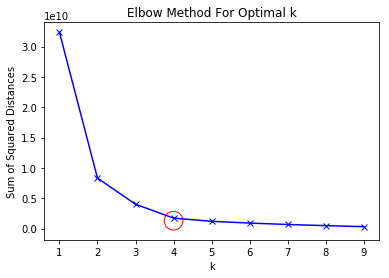

In [132]:
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.scatter(4, Sum_of_squared_distances[4]+100000000, s=350, facecolors='none', edgecolors='r')
plt.savefig('Elbow_Method_For_Optimal.png',bbox_inches='tight')

According to Elbow method the best k is 4

Let's apply k-means with k=4

In [133]:
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,).fit(df_grouped_clustering)


Insert labels to Dataframes

In [134]:
df_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Merge data into a single dataframe

In [135]:
df_merged = df_Paris
df_merged = df_merged.merge(neighborhoods_venues_sorted, right_on='Neighborhoods',left_on ='Neighborhood')

In [136]:
df_merged.head(2)

,borough,Rank,Neighborhood,Population,Area,Density,Longitude,Latitude,Distance_center,Cluster Labels,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1er arrondissementdit « du Louvre »,1er,Saint-Germain-l'Auxerrois,1672,"86,9",1 924,2.340195,48.860112,0.916353,0,...,French Restaurant,Hotel,Pizza Place,Bar,Italian Restaurant,Café,Clothing Store,Wine Bar,Steakhouse,Restaurant
1,1er arrondissementdit « du Louvre »,2e,Halles,8984,"41,2",21 806,2.344744,48.862541,0.824991,0,...,French Restaurant,Italian Restaurant,Pizza Place,Hotel,Bakery,Bar,Café,Tea Room,Steakhouse,Spa


In [137]:
df_merged['Cluster Labels'].value_counts()

0    30
3    21
2    18
1    11
Name: Cluster Labels, dtype: int64

Let's see the Paris map with colored clusters 

In [138]:
import folium
map_clusters_paris = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['Blueviolet','Deepskyblue','Limegreen','Red']
df_merged_paris = df_merged
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged_paris['Latitude'], df_merged_paris['Longitude'], \
                                  df_merged_paris['Neighborhood'], df_merged_paris['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters_paris)

#Add legend    
markers_legend = []
for i in range (len(rainbow)):
    markers_legend.append('&nbsp; Cluster {}&nbsp; <i class="fa fa-circle fa-1x" style="color:{}"></i><br>'.format(i,rainbow[i]))


legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 90px; min-height: 10px ;overflow: hidden; 
     border:2px solid grey; z-index:1000; font-size:13px; background-color: rgba(255, 255, 255, 0.6);
     "<br> '''
     #&nbsp; Cluster 0&nbsp; <i class="fa fa-circle fa-1x"
      #            style="color:#8000ff"></i><br>
     #&nbsp; Cluster 1&nbsp; <i class="fa fa-circle fa-1x"
      #            style="color:red"></i>
      #</div>
     #'''
legend_html = legend_html + '\n'.join(markers_legend) + '</div>'
map_clusters_paris.get_root().html.add_child(folium.Element(legend_html))
map_clusters_paris       
map_clusters_paris

Analyse result

See the Population distribution according to each cluster

In [139]:
dfclusters = df_grouped_clustering.groupby(['Cluster Labels']).mean().reset_index()

In [140]:
def get_cluster_population(i):
    return df_grouped_clustering[df_grouped_clustering['Cluster Labels'] == i ].Population

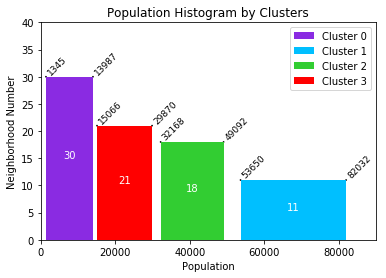

In [141]:
fig, ax = plt.subplots(figsize=(6,4))
props = {'ha': 'left', 'va': 'bottom'}
for i in range(kclusters):
    ser = get_cluster_population(i)
    mini = ser.min()
    maxi = ser.max()
    number_neighborhood = len(ser)
    name = "Cluster {}".format(i)
    ax = sns.distplot(ser,bins=1,kde=False,color=rainbow[i],hist_kws=dict(alpha=1),label=name) 
    ax.text(mini,number_neighborhood,mini,horizontalalignment='left',verticalalignment='bottom',rotation=45,\
           size=9)
    ax.text(maxi,number_neighborhood,maxi,horizontalalignment='left',verticalalignment='bottom',rotation=45,\
           size=9)
    pointx = (maxi+mini)/2
    pointy = number_neighborhood/2
    ax.text( pointx,pointy,number_neighborhood,color='w',horizontalalignment='center')
    #plt.scatter(((maxi+mini)/2),(number_neighborhood/2.0), s=150, facecolors='red', edgecolors='none')
    plt.scatter(mini, number_neighborhood, s=3, facecolors='black', edgecolors='none')
    plt.scatter(maxi, number_neighborhood, s=3, facecolors='black', edgecolors='none')
ax.set_xlim(0, 90000)
ax.set_ylim(0, 40)
plt.ylabel('Neighborhood Number')
ax.legend()
ax.locator_params(axis='x', nbins=6)
plt.title('Population Histogram by Clusters')
plt.savefig('Population_distribution.png',bbox_inches='tight')
plt.show()

Let's the Number of venues according to each cluster

Get the number of venues for each category according to a cluster

In [142]:
def category_distrubution(num_cluster): # 
    Cluster_top_category = {}
    keys = list(dict_categories_filter.keys())
    Cluster_top_category = {key: 0 for key in keys}
    for c in list_category_venues :
        val = dfclusters.iloc[num_cluster][c]
        top_category = check_categories(c)
        Cluster_top_category[top_category] +=val

    Cluster_top_category = pd.Series(Cluster_top_category)
    return Cluster_top_category[Cluster_top_category>0]
    

In [143]:
list_category_venues = list(df_grouped_clustering.columns)[1:-1]
df_result = pd.DataFrame(index=list(dict_categories_filter.keys()))
for i in range(kclusters):
 x = category_distrubution(i).sort_values(ascending=False)
 x.name = "cluster "+str(i)
 df_result = df_result.join(x)
df_result.sort_values('cluster 0',axis=0,ascending=False,inplace=True)


df_result

,cluster 0,cluster 1,cluster 2,cluster 3
Food,50.933333,27.727273,30.277778,42.857143
Shop & Service,14.700000,6.272727,4.555556,6.238095
Nightlife Spot,8.466667,4.818182,6.166667,7.047619
Travel & Transport,7.566667,3.545455,2.944444,6.333333
Arts & Entertainment,0.733333,0.454545,0.055556,0.619048
Outdoors & Recreation,0.466667,0.545455,0.888889,0.619048


Get the number of top 5 venues according to each cluster for food category 

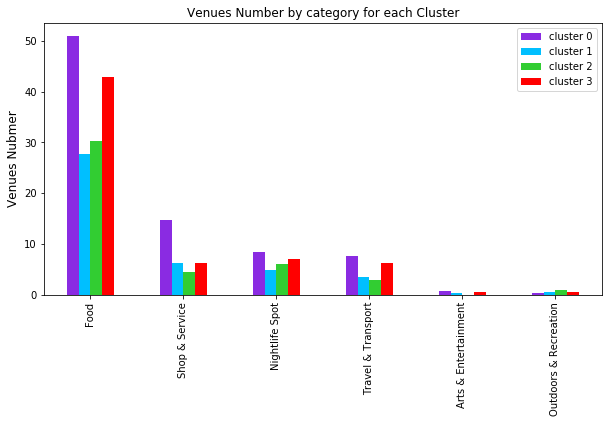

In [144]:
ax = df_result.plot.bar(color=rainbow,figsize=(10,5))
ax.set_ylabel("Venues Nubmer", fontsize=12)
plt.title('Venues Number by category for each Cluster')
plt.savefig('Figure1_result.png',bbox_inches='tight')  

In [145]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3

In [146]:
list_food = intersection(dict_categories_filter['Food'], list(dfclusters.columns))

In [153]:
res = pd.DataFrame()
for i in range(kclusters):
    x = dfclusters.iloc[i,0:-1].sort_values(ascending=False).head()
    x = x.to_frame(name='Number Venues')
    x['Cluster'] = 'Cluster {}'.format(i)
    x = x.rename_axis('sub_category').reset_index()
    res = res.append(x)

In [154]:
res

,sub_category,Number Venues,Cluster
0,French Restaurant,11.800000,Cluster 0
1,Hotel,7.500000,Cluster 0
2,Italian Restaurant,3.466667,Cluster 0
3,Japanese Restaurant,2.366667,Cluster 0
4,Café,2.233333,Cluster 0
0,French Restaurant,7.363636,Cluster 1
1,Hotel,3.363636,Cluster 1
2,Bar,3.363636,Cluster 1
3,Café,2.090909,Cluster 1
4,Bistro,1.727273,Cluster 1


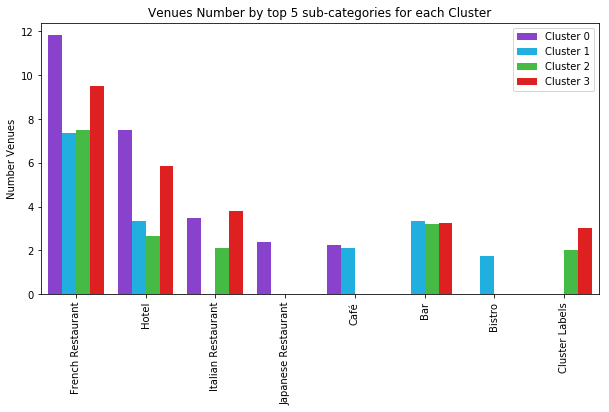

In [155]:
fig, ax = plt.subplots(figsize=(10,5))


ax = sns.barplot(x='sub_category',y='Number Venues',data=res,hue='Cluster',palette=rainbow)
rotation = 90 
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
plt.legend(loc='upper right')
plt.title('Venues Number by top 5 sub-categories for each Cluster')
plt.savefig('Figure2_result.png',pad_inches=0.5,bbox_inches='tight')

plt.show()

<hr>
<h3>Thanks for your follow up !!! </h3>